<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/Hunger_games_RF_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

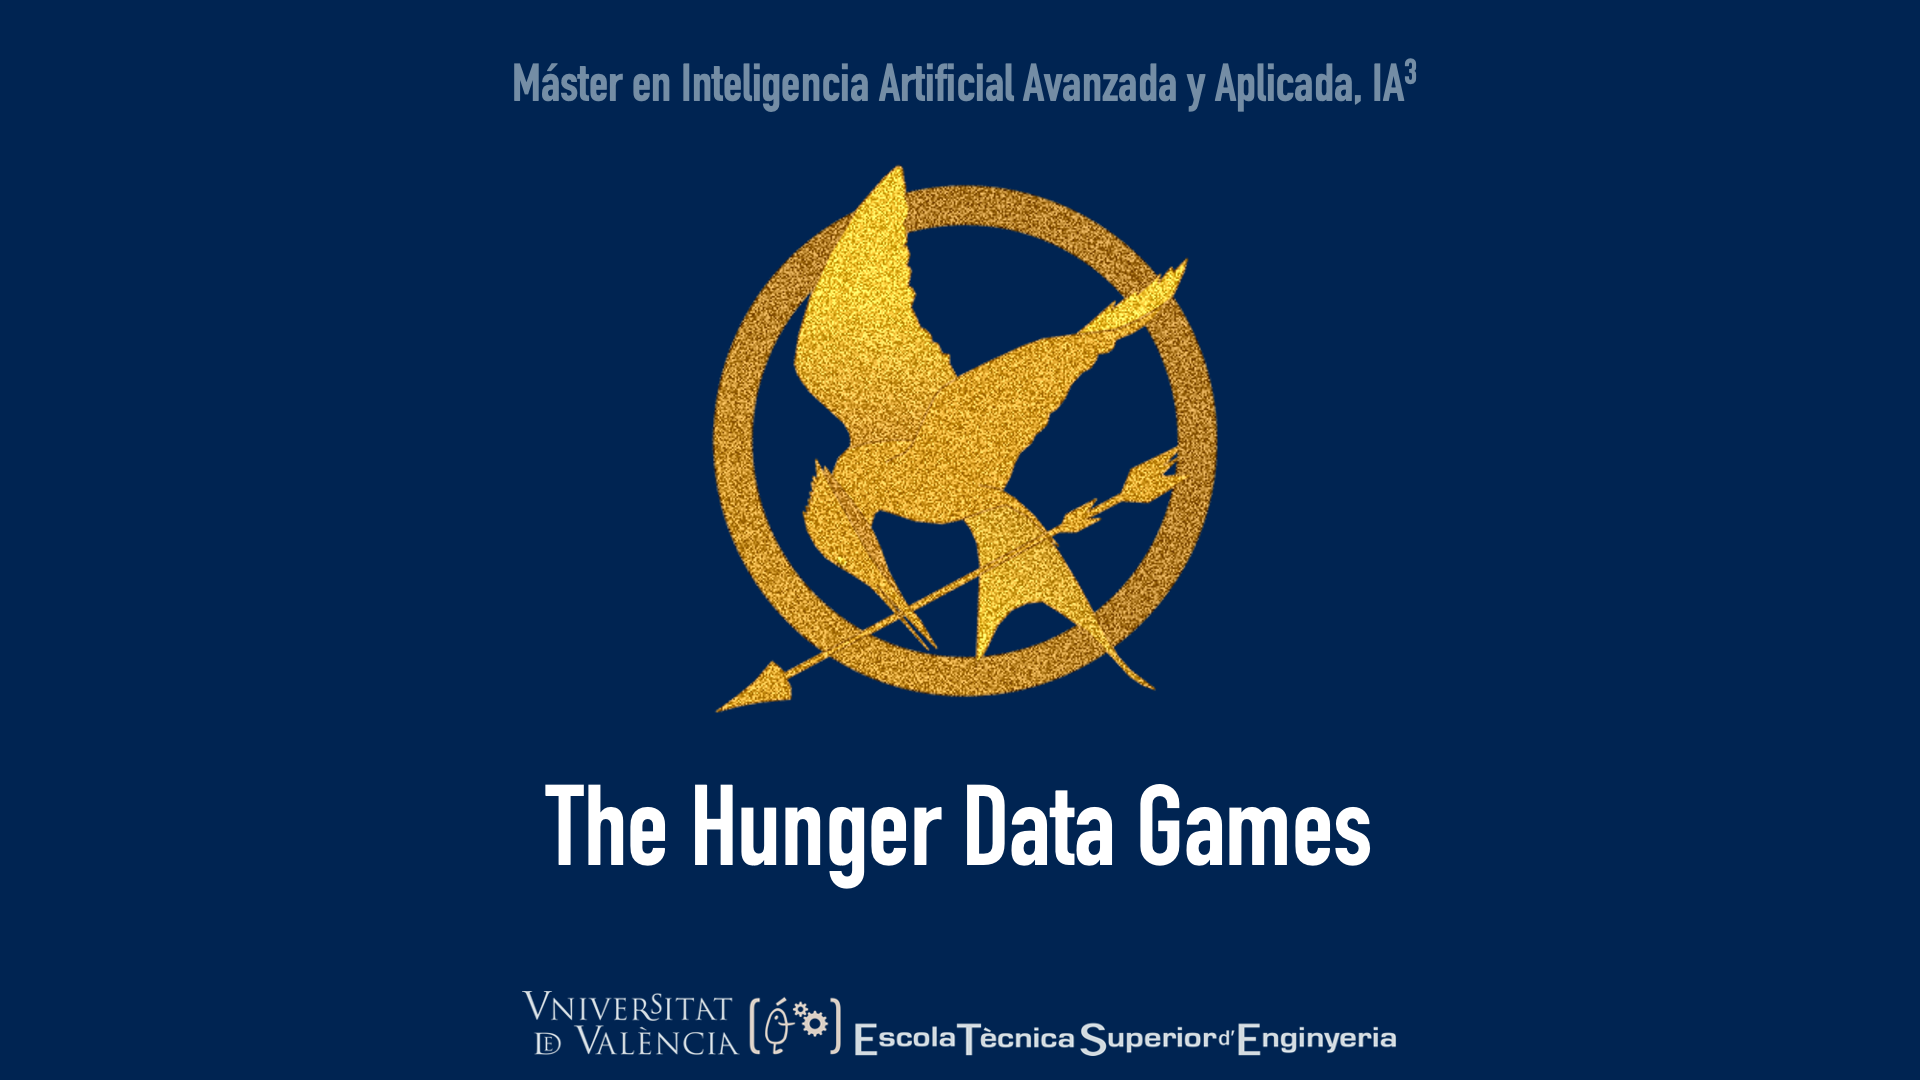

Wellcome to the first hunger data games!!! You have been selected as tributes from your sectors. In this edition you will be facing each other in a classification competition. The dataset you will be facing is this one:



A few recommendations for you to solve the exercise. Remember the different types of algorithm that we have studied and follow a natural path in building the exercise. Commence using a single estimator and try to build a bagging estimator.

For the evaluation metric check this webpage:

https://scikit-learn.org/stable/modules/model_evaluation.html

Specially check those called balanced_accuracy and f1_micro.

Finally the submission of the exercise must be a model file with the name of your team (find one which is cool I will add the coolness of the name to the final grade). 

Check this webpage for saving the model: https://scikit-learn.org/stable/modules/model_persistence.html

One more thing I will evaluate using the np.random.seed(123) use it for training your model.

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

np.random.seed(123)
url = "glass.csv"
dataframe = pd.read_csv(url)

dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

x = dataframe

dataframe.dropna(inplace=True)

X = dataframe.drop("type_of_glass",1)   #Feature Matrix
y = dataframe["type_of_glass"]          #Target Variable

x_t = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_t)
X = pd.DataFrame(x_scaled)

X.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron"]

Buscamos la importancia de cada una de las características

Feature: 0-refractive_index 	 Score: 0.0755879040116378
Feature: 1-sodium 	 Score: 0.060057446255872705
Feature: 2-magnesium 	 Score: 0.5674940413656082
Feature: 3-aluminum 	 Score: 0.05472394444609737
Feature: 4-silicon 	 Score: 0.026688643750887354
Feature: 5-potassium 	 Score: 0.03471002277107444
Feature: 6-calcium 	 Score: 0.09703447519460107
Feature: 7-barium 	 Score: 0.06870744718681412
Feature: 8-iron 	 Score: 0.01499607501740698


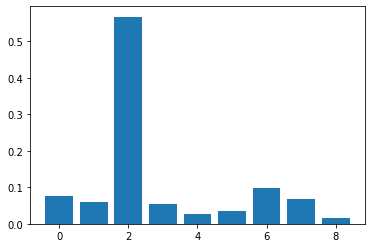

In [2]:
# define the model
model_imp = RandomForestRegressor()
# fit the model model.fit(X_train, y_train)
model_imp.fit(X, y)
# get importance
importance = model_imp.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
  print(f'Feature: {i}-{X.columns[i]} \t Score: {v}')
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Seleccionamos **magnesium** como la de mayor peso y comprobamos la correlación con las otras características 


refractive_index    0.122274
sodium              0.273732
aluminum            0.481799
silicon             0.165927
potassium           0.005396
calcium             0.443750
barium              0.492262
iron                0.083060
Name: magnesium, dtype: float64


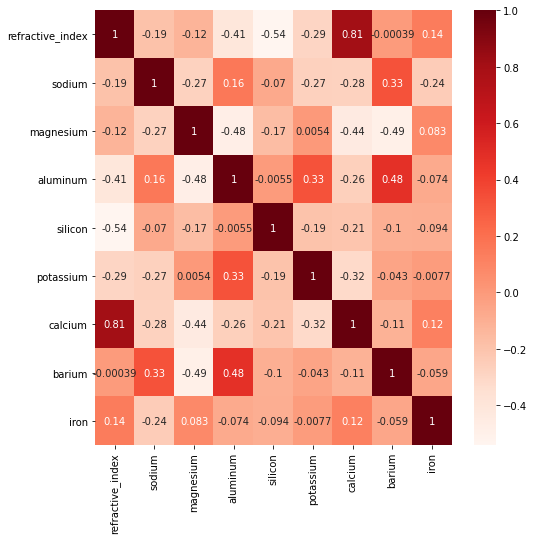

In [3]:
cor = X.corr()
cor_target = abs(cor['magnesium'])#Selecting highly correlated features
relevant_features = cor_target[cor_target<0.5]
print(relevant_features)
plt.figure(figsize=(8,8))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Buscamos correlación entre las características seleccionadas

In [4]:
feature_cols = ['magnesium','refractive_index','sodium','aluminum','silicon','potassium','calcium','barium','iron']
df_relevant_features = dataframe[feature_cols]
for feature in feature_cols:
  cor_relevant_features = df_relevant_features.corr()
  cor_target_feature = abs(cor_relevant_features[feature])
  relevant_features = cor_target_feature[cor_target_feature>0.5]
  print(relevant_features)

magnesium    1.0
Name: magnesium, dtype: float64
refractive_index    1.000000
silicon             0.542052
calcium             0.810403
Name: refractive_index, dtype: float64
sodium    1.0
Name: sodium, dtype: float64
aluminum    1.0
Name: aluminum, dtype: float64
refractive_index    0.542052
silicon             1.000000
Name: silicon, dtype: float64
potassium    1.0
Name: potassium, dtype: float64
refractive_index    0.810403
calcium             1.000000
Name: calcium, dtype: float64
barium    1.0
Name: barium, dtype: float64
iron    1.0
Name: iron, dtype: float64


1.   Eliminamos silicon y calcium por estar relacionadas con refractive_index
2.   Eliminamos refractive_index por estar relacionada con silicon y calcium y tener menos importacia que silicon y calcium
3.   Quitamos aquellos de menor importancia para conseguir un n_componentes = 5

In [5]:
feature_cols_op1 = ['magnesium','refractive_index','sodium','aluminum','potassium','barium','iron']
feature_cols_op2 = ['magnesium','sodium','aluminum','calcium']
feature_cols_op3 = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron"]

In [6]:
from sklearn.preprocessing import label_binarize
classes=[1, 2, 3 , 5 ,6 ,7]
y = label_binarize(y, classes)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

In [7]:
def launch_model(feature_, n_estimators_, random_state_):
  X_selected_features = dataframe[feature_] # Features
  X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.385, random_state=1)
  model = RandomForestClassifier()
  clf = model.fit(X_train, y_train)
  y_score = clf.predict(X_test)

  print(f"Score: {model.score(X_train, y_train)}")
  print("Accuracy:",metrics.accuracy_score(y_test, y_score))
  print(f"F1_micro: {metrics.f1_score(y_test, y_score, average='micro')}")

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Score: 1.0
Accuracy: 0.5783132530120482
F1_micro: 0.6357615894039735


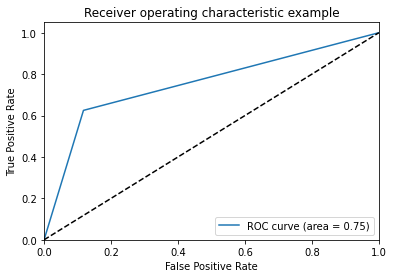

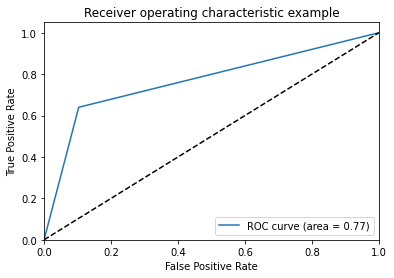

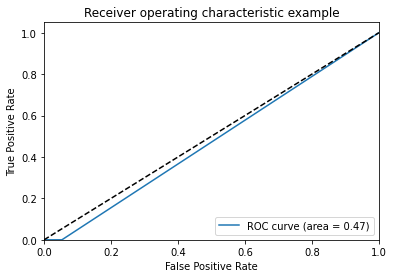

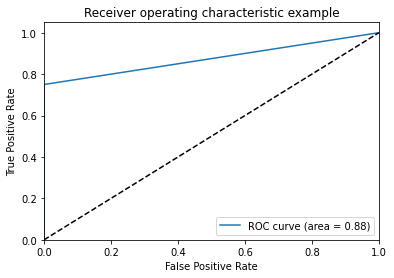

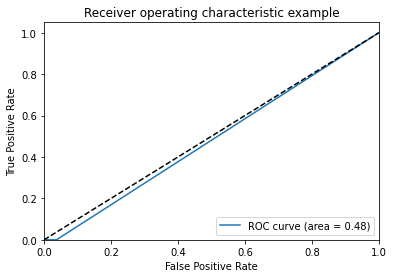

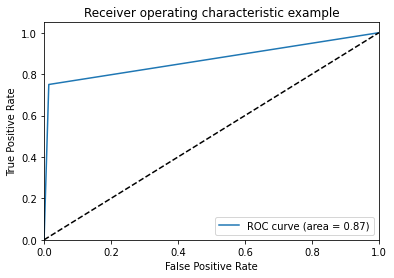

In [8]:
launch_model(feature_cols_op2,400,42)

Score: 1.0
Accuracy: 0.6265060240963856
F1_micro: 0.7222222222222222


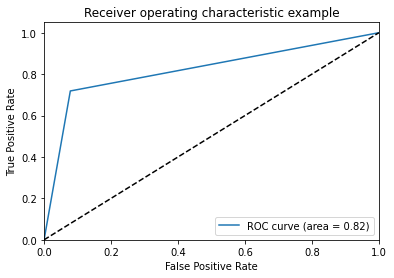

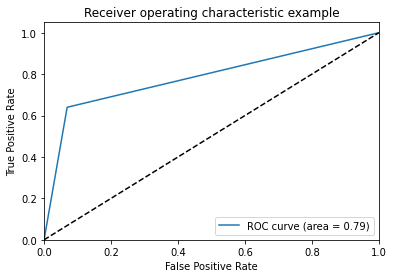

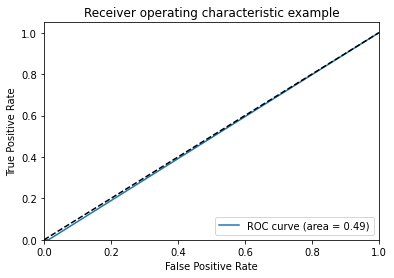

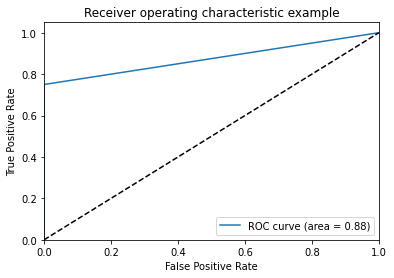

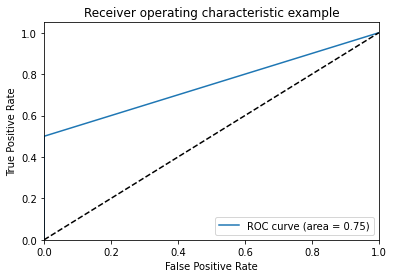

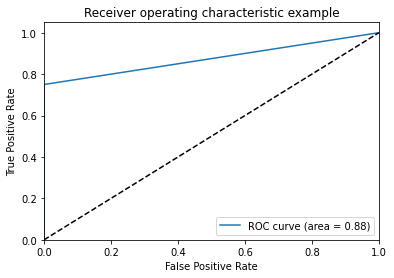

In [9]:
launch_model(feature_cols_op3,400,42)

Score: 1.0
Accuracy: 0.6144578313253012
F1_micro: 0.7183098591549295


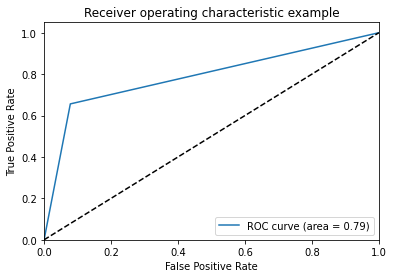

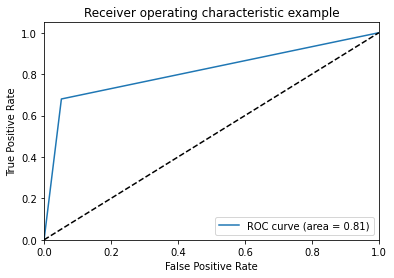

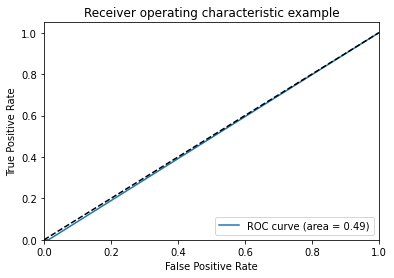

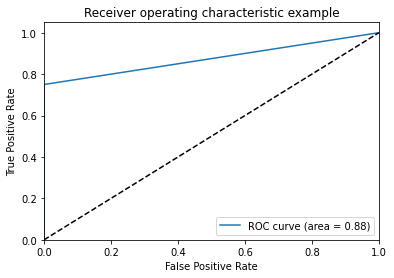

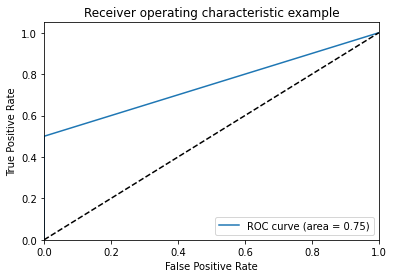

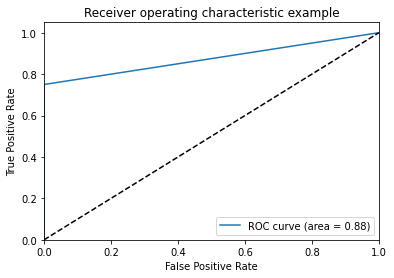

In [10]:
launch_model(feature_cols_op1,400,42)